# Load data from csv files

In [1]:
import pandas as pd

In [5]:
# Read data from csv files
label = pd.read_csv('BurnedArea-100k.csv')
elevation = pd.read_csv('Elevation-100k.csv')
forest = pd.read_csv('Forest-100k.csv')
humanMod = pd.read_csv('HumanModification-100k.csv')
leaf = pd.read_csv('LeafArea-100k.csv')
rain = pd.read_csv('Precipitation-100k.csv')
radiation = pd.read_csv('Radiation-100k.csv')
soil = pd.read_csv('SoilType-100k.csv')
temp = pd.read_csv('Temperature-100k.csv')

In [7]:
elevation.head()

,system:index,elevation
0,0_0,922
1,1_0,14
2,3_0,939
3,4_0,1911
4,5_0,295


In [8]:
# Merge all dataframes via inner join
samples = pd.merge(left=elevation, right=forest, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=humanMod, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=leaf, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=rain, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=radiation, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=soil, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=temp, left_on='system:index', right_on='system:index')

In [18]:
fireIdx = label.copy()
del fireIdx['BurnDate']
del fireIdx['FirstDay']
del fireIdx['LastDay']
del fireIdx['QA']
del fireIdx['BurnMonth']
fireIdx.head()

,system:index,Uncertainty
0,145_0,2
1,149_0,2
2,188_0,3
3,203_0,1
4,416_0,3


In [123]:
# Label samples
samplesCopy = samples.copy()
samplesCopy = pd.merge(left=fireIdx, right=samplesCopy, how='right', left_on='system:index', right_on='system:index')

sampleLabel = samplesCopy['Uncertainty'].fillna(100).tolist()
firstNoFireIdx = sampleLabel.index(100)

# Drop label column
del samplesCopy['Uncertainty']
print(len(samplesCopy.columns))
samplesList = samplesCopy.values.tolist()
fireSamples = samplesList[:firstNoFireIdx]
fireUncertain = sampleLabel[:firstNoFireIdx]
noFireSamples = samplesList[firstNoFireIdx:]
noFireLabel = [0 for _ in range(len(noFireSamples))]

46


In [37]:
print(len(fireLabel))
print(len(noFireLabel))

1051
79537


In [124]:
from sklearn.model_selection import train_test_split
X_fire_train, X_fire_test, y_fire_train, y_fire_test = train_test_split(fireSamples, fireUncertain, test_size=0.2, random_state=0)
X_no_fire_train, X_no_fire_test, y_no_fire_train, y_no_fire_test = train_test_split(noFireSamples, noFireLabel, test_size=0.9, random_state=42)

In [43]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [84]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

# Binary Classification

In [206]:
rf = RandomForestClassifier(n_estimators=50, max_features=19, max_leaf_nodes=390, max_depth=20, min_samples_leaf=1, min_samples_split=3, random_state=20, n_jobs=-1)
y_fire_train_1 = [1 for _ in range(len(y_fire_train))]
y_fire_test_1 = [1 for _ in range(len(y_fire_test))]
X_train = X_fire_train + X_no_fire_train
y_train = y_fire_train_1 + y_no_fire_train
rf = rf.fit(X_train, y_train)
y_fire_pred_msk = rf.predict(X_fire_test)
np.mean(y_fire_test_1 == y_fire_pred_msk)

0.7535545023696683

# Confusion Matrix for Binary Classification

In [ ]:
yy_test = y_fire_test + y_no_fire_test
#rint(yy_test)
print(type(y_fire_pred))
yy_pred = np.append(y_fire_pred, y_no_fire_pred)
cm = confusion_matrix(yy_test, yy_pred)

# Only uses the labels that appear in the data
labels = unique_labels(yy_test, yy_pred)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

# Hyperparamters Adjust to avoid outfit

In [99]:
# Dynamics of max_features
feature_number = []
predic = []
for i in range(1, 47):
    rf = RandomForestClassifier(n_estimators=50, max_features=i, random_state=20, n_jobs=-1)
    X_train = X_fire_train + X_no_fire_train
    y_train = y_fire_train + y_no_fire_train
    rf = rf.fit(X_train, y_train)
    y_fire_pred = rf.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred))
    feature_number.append(i)

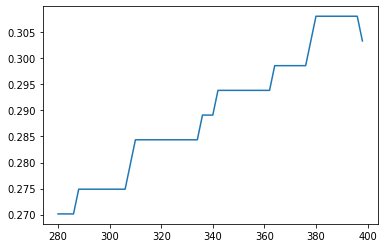

In [195]:
# Dynamics of max_leaf_nodes
max_leaf = []
predic = []
for i in range(140, 200):
    rf = RandomForestClassifier(n_estimators=50, max_features=19, max_leaf_nodes=i*2, random_state=20, n_jobs=-1)
    X_train = X_fire_train + X_no_fire_train
    y_train = y_fire_train + y_no_fire_train
    rf = rf.fit(X_train, y_train)
    y_fire_pred = rf.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred))
    max_leaf.append(i*2)
plt.plot(max_leaf, predic)

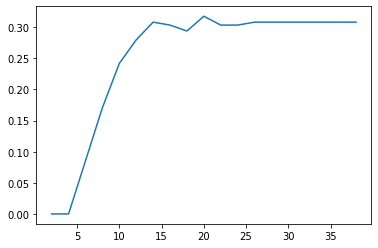

In [199]:
# Dynamics of max_depth
depth = []
predic = []
for i in range(1, 20):
    rf = RandomForestClassifier(n_estimators=50, max_features=19, max_leaf_nodes=390, max_depth=i*2, random_state=20, n_jobs=-1)
    X_train = X_fire_train + X_no_fire_train
    y_train = y_fire_train + y_no_fire_train
    rf = rf.fit(X_train, y_train)
    y_fire_pred = rf.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred))
    depth.append(i*2)
plt.plot(depth, predic)

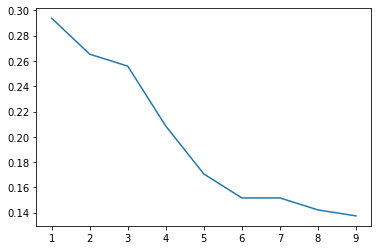

In [193]:
# Dynamics of min_samples_leaf
leaf = []
predic = []
for i in range(1, 10):
    rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=i, random_state=20, n_jobs=-1)
    X_train = X_fire_train + X_no_fire_train
    y_train = y_fire_train + y_no_fire_train
    rf = rf.fit(X_train, y_train)
    y_fire_pred = rf.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred))
    leaf.append(i)
plt.plot(leaf, predic)

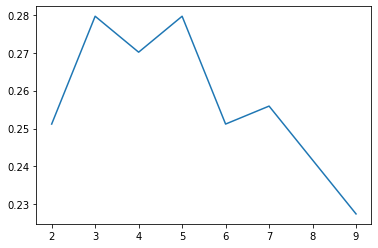

In [204]:
# Dynamics of min_samples_split
split = []
predic = []
for i in range(2, 10):
    rf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=390, max_depth=20, min_samples_leaf=1, min_samples_split=i, random_state=20, n_jobs=-1)
    X_train = X_fire_train + X_no_fire_train
    y_train = y_fire_train + y_no_fire_train
    rf = rf.fit(X_train, y_train)
    y_fire_pred = rf.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred))
    split.append(i)
plt.plot(split, predic)

In [117]:
ws = list(zip(samplesCopy.columns, rf.feature_importances_))
ws

[('system:index', 0.009930155040047555),
 ('elevation', 0.013498682898465352),
 ('fnf', 0.0017655181609825348),
 ('gHM', 0.019824183162524624),
 ('Fpar', 0.02762596727494695),
 ('FparExtra_QC', 0.008120551467234975),
 ('FparLai_QC', 0.0016796477623498153),
 ('FparStdDev', 0.018137092299869133),
 ('Lai', 0.02058386223340125),
 ('LaiStdDev', 0.010231918246334295),
 ('apr', 0.01142362568936664),
 ('aug', 0.012278413433161398),
 ('dec', 0.025604653223590314),
 ('feb', 0.04145649342701823),
 ('jan', 0.02829364268307765),
 ('jul', 0.010262768202345573),
 ('jun', 0.0063906448039201145),
 ('mar', 0.019214091921095813),
 ('may', 0.029457737307380324),
 ('nov', 0.01447288399932782),
 ('oct', 0.04490112133055457),
 ('sep', 0.008536749821565043),
 ('bi', 0.023112989306202772),
 ('erc', 0.0208792678394877),
 ('eto', 0.019201176656506985),
 ('etr', 0.017959331471854374),
 ('fm100', 0.01358446830296671),
 ('fm1000', 0.019954954034818194),
 ('pr', 0.022909201336616274),
 ('rmax', 0.0173209786711317),


In [118]:
y_no_fire_pred = rf.predict(X_no_fire_test)
np.mean(y_no_fire_pred == y_no_fire_test)

#print(y_fire_pred)
#print(y_no_fire_test)
#print(y_no_fire_pred)
#print(np.mean((y_no_fire_pred + y_fire_pred) == (y_no_fire_test + y_fire_pred)))

0.9921770227983907

# Multi-Classification

In [200]:
rf2 = RandomForestClassifier(n_estimators=5, max_features=38, max_leaf_nodes=116, max_depth=2, random_state=20, n_jobs=-1)
rf2 = rf2.fit(X_fire_train, y_fire_train)
y_fire_pred_multi = rf2.predict(X_fire_test)
print(np.mean((y_fire_test == y_fire_pred_multi) * y_fire_pred_msk))
result = []
for i, true_val in enumerate(y_fire_test):
    if abs(true_val - y_fire_pred_multi[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_fire_pred_msk))
#np.mean(result)

0.22748815165876776
0.7061611374407583


# Confusion Matrix for Multi-Classification

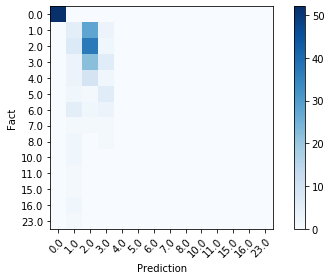

In [201]:
y_test_multi = y_fire_test * y_fire_pred_msk
y_pred_multi = y_fire_pred_multi * y_fire_pred_msk
cm = confusion_matrix(y_test_multi, y_pred_multi)

# Only uses the labels that appear in the data
labels = unique_labels(y_test_multi, y_pred_multi)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

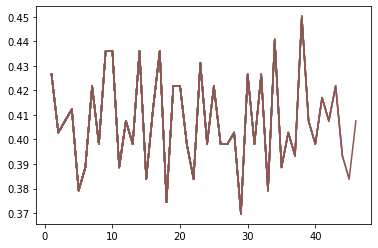

In [161]:
# Dynamics of max_features
feature_num = []
predic = []
for i in range(1, 47):
    rf2 = RandomForestClassifier(n_estimators=5, max_features=i, random_state=20, n_jobs=-1)
    rf2 = rf2.fit(X_fire_train, y_fire_train)
    y_fire_pred_multi = rf2.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred_multi))
    feature_num.append(i)
    plt.plot(feature_num, predic)

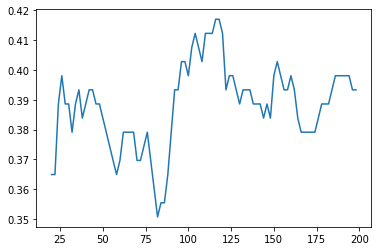

In [169]:
# Dynamics of max_leaf_nodes
max_leaf = []
predic = []
for i in range(10, 100):
    rf2 = RandomForestClassifier(n_estimators=5, max_features=38, max_leaf_nodes=i*2, random_state=20, n_jobs=-1)
    rf2 = rf2.fit(X_fire_train, y_fire_train)
    y_fire_pred_multi = rf2.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred_multi))
    max_leaf.append(i*2)
plt.plot(max_leaf, predic)

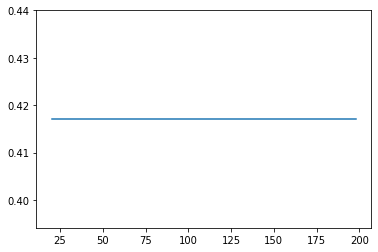

In [172]:
# Dynamics of max_depths
depth = []
predic = []
for i in range(10, 100):
    rf2 = RandomForestClassifier(n_estimators=5, max_features=38, max_leaf_nodes=116, max_depth=i*2, random_state=20, n_jobs=-1)
    rf2 = rf2.fit(X_fire_train, y_fire_train)
    y_fire_pred_multi = rf2.predict(X_fire_test)
    predic.append(np.mean(y_fire_test == y_fire_pred_multi))
    depth.append(i*2)
plt.plot(depth, predic)

# Metrics

In [120]:
print(classification_report(yy_test, yy_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71584
           1       0.22      0.75      0.34       211

    accuracy                           0.99     71795
   macro avg       0.61      0.87      0.67     71795
weighted avg       1.00      0.99      0.99     71795

